In this lab, you are supposed to do the following tasks related to Kalman filtering and smoothing.

1. Simulation of an LGSSM.
2. Solve the filtering problem with a Kalman filter.
3. Solve the smoothing problem with a Kalman smoother.

We will use the Newtonian dynamics model in LE 3 as the example.

To pass this assignment, you need to pass all the tasks and answer the questions (except for those marked optional). You are also asked to report the contributions if you worked in a team.

## Note
To get a result consistent with the teacher's:

1. Use "Run All".
2. Do not change the random seed.
3. Do not change the plotting settings. If you encounter any issue related to LaTeX rendering, you can comment out the `text.usetex: True` item in `plt.rcParams.update`.

# Some naming conventions

In this lecture we often use the following naming conventions for variables.

- `m` usually denotes a mean vector.
- `v` usually denotes a covariance matrix.
- `mf` usually denotes a filtering mean vector.
- `vf` usually denotes a filtering covariance matrix.
- `mfs` (plural) usually denotes many filtering mean vectors, in particular, an array of filtering means at each time step. For example, if `mf` has shape `(d, )`, then `mfs` has shape `(n, d)`, where `n` is the number of time steps.
- `mfss` plural of `mfs`, having shape `(c, n, d)` with another leading dimension. Similarly goes for `mfsss` ...
- `mss` (plural) usually denotes an array of smoothing means.

# Setup
Let's first import the necessary libraries and set a random seed.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from typing import Tuple

np.random.seed(777)

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 20})

# Task 1: Define an LGSSM and simulate a path
Your first task is to simulate a state path $X_{0:N} \coloneqq \lbrace X_0, X_1, \ldots, X_N \rbrace$ and observation path $Y_{0:N} \coloneqq \lbrace Y_0, Y_1, \ldots, Y_N \rbrace$ from a state-space model.
The example model here is an LGSSM that describes the Newtonian dynamics of a moving object in 2D space, and we assume that we observe the position of the object with Gaussian noise.

$$
\begin{equation}
    \begin{split}
        X_0 &\sim \mathrm{N}(m_0, V_0), \\
        X_k &= A \, X_{k-1} + q_k, \quad q_k \sim \mathrm{N}(0, \Sigma), \\
        Y_k &= H \, X_k + \xi_k, \quad \xi_k \sim \mathrm{N}(0, \Xi).
    \end{split}
\end{equation}
$$
where $X_k = \begin{bmatrix}p_k^1 & p_k^2 & v_k^1 & v_k^2\end{bmatrix}$ encodes the position and velocity of the object at time $t_k$ in the 2D space, and
$$
A =
\begin{bmatrix}
    1 & 0 & \Delta & 0\\
    0 & 1 & 0 & \Delta \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1
\end{bmatrix}, \quad
\Sigma =
\begin{bmatrix}
    \Delta^3/3 & 0 & \Delta^2/2 & 0\\
    0 & \Delta^3/3 & 0 & \Delta^2/2\\
    \Delta^2/2 & 0 & \Delta & 0\\
    0 & \Delta^2/2 & 0 & \Delta
\end{bmatrix}.
$$

The measurement model is given by
$$
H =
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
\end{bmatrix}, \quad
\Xi = 0.5 \, I_2
$$

which means that we observe the position of the object with Gaussian noise.

We consider that the object moves within time $t=[0, T]$, where $T = 10$ seconds, and we discretise the time with $N=100$ steps, resulting in a time step size of $\Delta = 0.1$ seconds.

In [4]:
t0 = 0.  # The initial time
nsteps = 100  # The number of time steps
T = 10.  # The final time
ts = np.linspace(t0, T, nsteps + 1)  # The times
dt = T / nsteps  # The time step size \Delta

Now we want to simulate a path $X_{0:N}$ from the LGSSM at the time steps $t_0 < t_1 < \cdots < t_N = T$, and the corresponding observations $Y_{0:N}$.

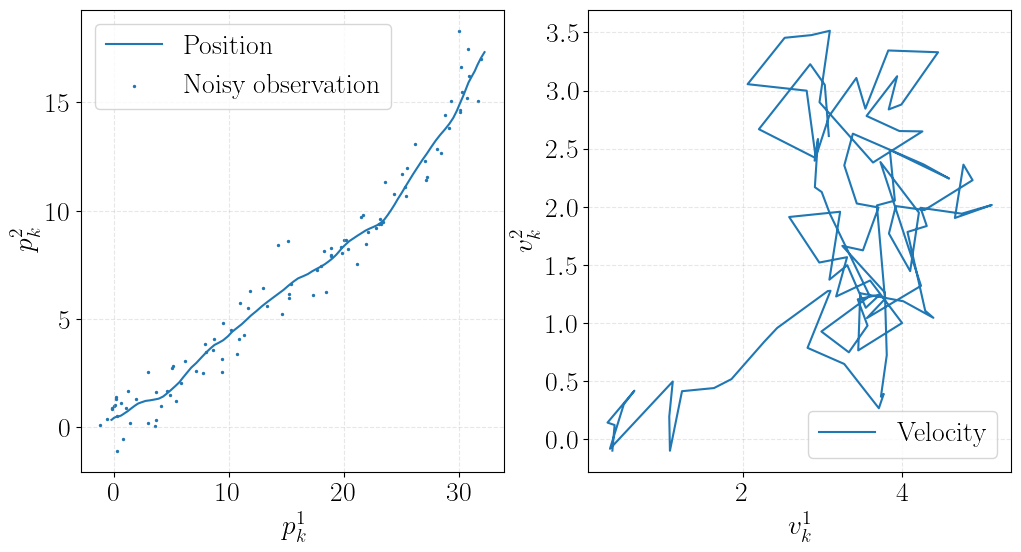

In [7]:
d = 4  # The dimension of the state
dy = 2  # The dimension of the observation

A = np.array([[1, 0, dt, 0],
                  [0, 1, 0, dt],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]])

Sigma = np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0],
                  [0, dt ** 3 / 3, 0, dt ** 2 / 2],
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])
xi = 0.5 * np.eye(dy)

# Pre-allocate a container to store the states (note that this includes X0)
xs = np.zeros((nsteps + 1, d))
ys = np.zeros((nsteps + 1, dy))

# The initial state
#其背后原理是：如果你想从一个均值为 μ，协方差为 Σ 的正态分布中采样，
#你可以先从标准正态分布 N(0,I) 中生成一个随机向量 z，然后通过线性变换得到所需的向量 x=μ+Lz，
#其中 L 是 Σ 的乔列斯基分解。
m0, v0 = np.zeros(d), np.eye(d)
x0 = m0 + np.linalg.cholesky(v0) @ np.random.randn(d)

# xi ** 0.5: 对噪声协方差矩阵 xi 中的每个元素进行开方。
# 由于 xi 是对角矩阵，这个操作等价于求其乔列斯基分解
y0 = H @ x0 + xi ** 0.5 @ np.random.randn(dy)
xs[0] = x0
ys[0] = y0

# Simulate a path from the LGSSM
for k in range(1, nsteps + 1):
    xs[k] = A @ xs[k-1] + np.linalg.cholesky(Sigma) @ np.random.randn(d)
    ys[k] = H @ xs[k] + xi ** 0.5 @ np.random.randn(dy)

fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(ys[:, 0], ys[:, 1], s=2, label='Noisy observation')
_ = axes[1].plot(xs[:, 2], xs[:, 3], label='Velocity')

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$v^1_k$')
axes[1].set_ylabel('$v^2_k$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')

In [17]:
np.random.randn(2)

array([0.37125335, 0.41082268])

# Task 2: Kalman filtering

The filtering problem aims to estimate the hidden states $X_k$ given the observations $Y_{0:k}$ for $k=0,1,\ldots$.
In the stochastic setting, this means to solve for the posterior distribution $p(x_k \mid y_{0:k})$.
Since we have an LGSSM, the filtering posterior is Gaussian, and the posterior means and covariances be computed in closed with a Kalman filter.

We will use the path of the model you have just simulated. Specifically, we will use the observations $Y_{0:N}$ as the input to the Kalman filter, and then estimate the hidden state to compare to the true path $X_{0:N}$ you simulated.

Implement the Kalman filter. Check the pseudo-code in the lecture notes.

# Important note

In the Kalman filter update step, we need to solve for a matrix inversion.
Surely you can use the `np.linalg.inv` function, and you will still get a pass, but it is not a great idea.
A better idea is to use the Cholesky decomposition to solve for a linear system.
You can use `scipy.linalg.cho_factor` and `scipy.linalg.cho_solve` for this purpose.
But again, this is optional. You can still use `np.linalg.inv` if you want to.

In [ ]:
def kf_pred(mf: np.ndarray,
            vf: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Given previous filtering mean and covariance, compute the predicted mean and covariance

    Parameters
    ----------
    mf : (d, )
        The filtering mean at time k-1.
    vf : (d, d)
        The filtering covariance at time k-1.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The predicted mean and covariance for p(x_k | y_{0:k-1}) at time k.
    """

    # The term np.linalg.cholesky(Sigma) @ np.random.randn(d) is a sampling operation used to generate a sample of the process noise. 
    # In the EKF, you don't sample the noise; you add its covariance matrix (Q) to the propagated state covariance. 
    # The covariance is a statistical property, not a single realization.
    return (A @ mf,A @ vf @ A.T + Sigma)


def kf_update(mp: np.ndarray,
              vp: np.ndarray,
              yk: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Given the predicted mean mp and covariance vp, do a Bayesian update the new observation yk, to get the current filtering mean and covariance

    Parameters
    ----------
    mp : (d, )
        The predicted mean at time k.
    vp : (d, d)
        The predicted covariance at time k.
    yk : (dy, )
        The observation at time k.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The filtering mean and covariance for p(x_k | y_{0:k}).
    """
    # s: innovation covariance
    s = H @ vp @H.T + xi
    c = vp @ H.T

    # Cholesky分解
    cho_fac, lower = scipy.linalg.cho_factor(s)
    K = scipy.linalg.cho_solve((cho_fac, lower), c.T).T

    mf = mp + K @ (yk - H @ mp)
    vf = vp - K  @ c.T
    return mf, vf


def kf(m0: np.ndarray,
       v0: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """The Kalman filter implementation.

    Parameters
    ----------
    m0 : (d, )
        The initial filtering mean.
    v0 : (d, d)
        The initial filtering covariance.

    Returns
    -------
    (nsteps + 1, d), (nsteps + 1, d, d), (nsteps + 1, d), (nsteps + 1, d, d)
        The filtering means, filtering covariances, predictive means, and predictive covariances.
    """
    # Create a container to dump the filtering results
    mfs = np.zeros((nsteps + 1, d))  # Filtering means
    vfs = np.zeros((nsteps + 1, d, d))  # Filtering covariances

    # Also create a container to dump the predictive means and covariances for later use by the RTS smoother
    # Note: since we only need the predictive means and covariances for k=1,2,...,N, the first time elements of these arrays are not used.
    mps = np.zeros((nsteps + 1, d))
    vps = np.zeros((nsteps + 1, d, d))

    # The initial step
    mf0, vf0 = kf_update(m0, v0, y0)
    mfs[0] = mf0
    vfs[0] = vf0

    # KF loop
    for k in range(1, nsteps + 1):
        mp, vp = kf_pred(mfs[k-1],vfs[k-1])
        mfs[k], vfs[k] = kf_update(mp, vp, ys[k])

        mps[k], vps[k] = mp, vp

    return mfs, vfs, mps, vps


mfs, vfs, mps, vps = kf(m0, v0)

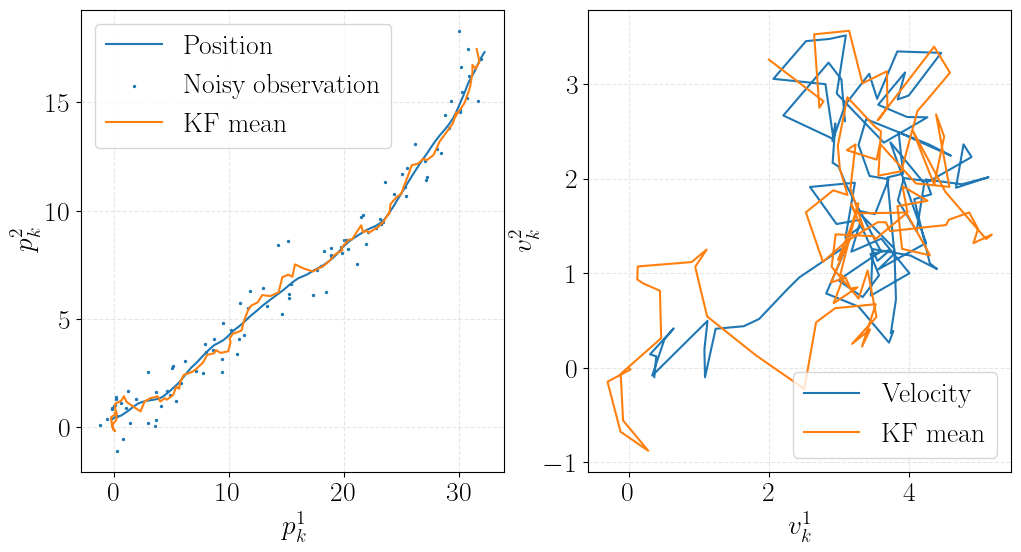

In [11]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(ys[:, 0], ys[:, 1], s=2, label='Noisy observation')
_ = axes[0].plot(mfs[:, 0], mfs[:, 1], label='KF mean')

_ = axes[1].plot(xs[:, 2], xs[:, 3], label='Velocity')
_ = axes[1].plot(mfs[:, 2], mfs[:, 3], label='KF mean')

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$v^1_k$')
axes[1].set_ylabel('$v^2_k$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')

# Task 3: Kalman/RTS smoothing

The smoothing problem also aims to estimate the hidden states, but compared to the filtering problem, it uses *all* the observations $Y_{0:N}$ to estimate the hidden states $X_k$ for $k=0,1,\ldots,N$ at a fixed time horizon. Formally, this means to solve for the posterior distribution $p(x_k \mid y_{0:N})$ for $k=0,1,\ldots, N$.

For LGSSMS, the smoothing posterior is also Gaussian, and the posterior means and covariances can be computed in closed form with a Kalman/RTS smoother.

Implement the Kalman/RTS smoother. Check the pseudo-code in the lecture notes.

In [30]:
def rts(mfs: np.ndarray,
        vfs: np.ndarray,
        mps: np.ndarray,
        vps: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """The RTS smoother implementation.

    Parameters
    ----------
    mfs : (nsteps + 1, d)
        The filtering means.
    vfs : (nsteps + 1, d, d)
        The filtering covariances.
    vps : (nsteps + 1, d, d)
        The predictive covariances.
    mps : (nsteps + 1, d)
        The predictive means.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray]
        The smoothing means and covariances.
    """
    # Create a container to dump the smoothing results
    mss = np.zeros((nsteps + 1, d))  # Smoothing means
    vss = np.zeros((nsteps + 1, d, d))  # Smoothing covariances

    # Terminal
    mss[-1] = mfs[-1]
    vss[-1] = vfs[-1]

    for k in reversed(range(nsteps)):

        # 使用Cholesky分解替代直接求逆
        # G = vfs[k] @ A.T @ np.linalg.inv(vps[k+1])  # 原来的方法

        # 计算 G = vfs[k] @ A.T @ vps[k+1]^(-1)
        # 使用Cholesky分解求解线性系统
        C = vfs[k] @ A.T  # shape: (d, d)
        cho_fac, lower = scipy.linalg.cho_factor(vps[k+1])

        G = scipy.linalg.cho_solve((cho_fac, lower), C.T).T
        mss[k] = mfs[k] + G @ (mss[k+1]-mps[k+1])
        vss[k] = vfs[k] + G @ (vss[k+1]-vps[k+1]) @G.T
    return mss, vss


mss, vss = rts(mfs, vfs, mps, vps)

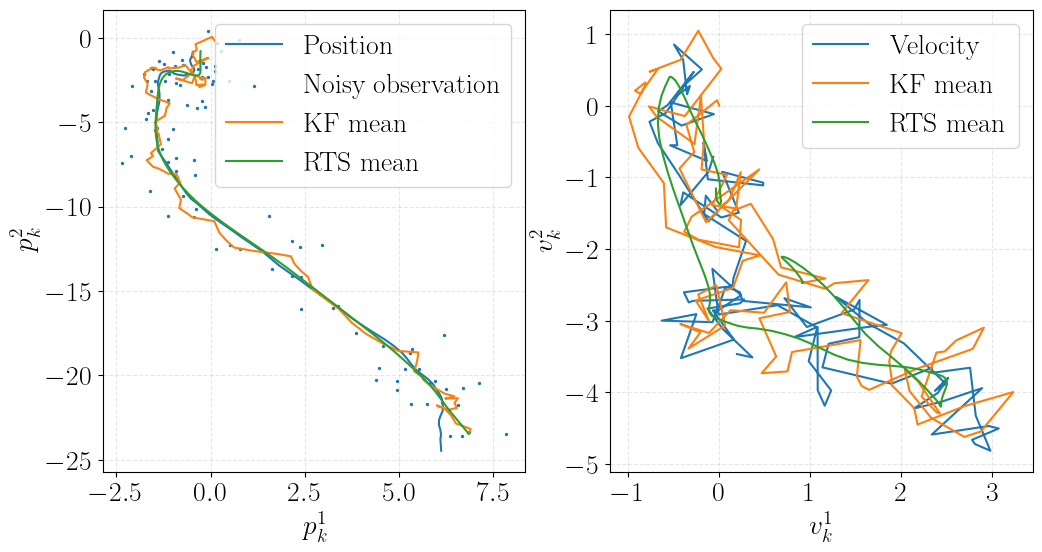

In [31]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
_ = axes[0].plot(xs[:, 0], xs[:, 1], label='Position')
_ = axes[0].scatter(ys[:, 0], ys[:, 1], s=2, label='Noisy observation')
_ = axes[0].plot(mfs[:, 0], mfs[:, 1], label='KF mean')
_ = axes[0].plot(mss[:, 0], mss[:, 1], label='RTS mean')

_ = axes[1].plot(xs[:, 2], xs[:, 3], label='Velocity')
_ = axes[1].plot(mfs[:, 2], mfs[:, 3], label='KF mean')
_ = axes[1].plot(mss[:, 2], mss[:, 3], label='RTS mean')

axes[0].legend()
axes[1].legend()

axes[0].set_xlabel('$p^1_k$')
axes[0].set_ylabel('$p^2_k$')
axes[1].set_xlabel('$v^1_k$')
axes[1].set_ylabel('$v^2_k$')

for ax in axes:
    ax.grid(linestyle='--', alpha=0.3, which='both')

# Compare the results

The Kalman filter and smoother are essentially two estimators for the hidden states.
Since now we know the true path $X_{0:N}$, it is straightforward to use the root mean square error (RMSE) to compare the results of the Kalman filter and smoother.

$$
\mathrm{RMSE} = \sqrt{\frac{1}{d \,N} \sum_{k=0}^{N} \lVert X_k - \widehat{X}_k \rVert^2_2},
$$

where we replace $\widehat{X}_k$ with the filter/smoother mean $m^f_k$ / $m^s_k$.

In [32]:
rmse_kf = np.sqrt(np.sum((xs-mfs)**2)/d/nsteps)
rmse_rts = np.sqrt(np.sum((xs-mss)**2)/d/nsteps)

print(f'Kalman filter RMSE: {rmse_kf:.3f}')
print(f'Kalman smoother RMSE: {rmse_rts:.3f}')

Kalman filter RMSE: 0.629
Kalman smoother RMSE: 0.340


# Question 1

Given that we know the true path, is RMSE the best metric to gauge the estimators? If not, what is missing from the RMSE?

NO, it is not the best metric as it only evaluated the difference between mean values but ignores the uncertainty estimation of covariances.
# Question 2

What if we do not know the true path? How would you then evaluate the performance of the estimators?

Innovation-based Metrics:

Innovation Sequence Analysis: The innovations (prediction errors) should be white noise if the filter is working correctly
Normalized Innovation Squared (NIS): Should follow a chi-squared distribution with degrees of freedom equal to observation dimension
Innovation Covariance: Should match the theoretical innovation covariance

# Question 3

Why is it not a good idea to use `np.linalg.inv` to solve the matrix inversion in the Kalman filter update step (and the RTS smoother)? How would you solve it properly and give a short code snippet to illustrate your solution?
(if you have already implemented the update step with Cholesky, you only need to explain why it is a better idea than matrix inversion)

Why np.linalg.inv is problematic:
Numerical instability: Direct matrix inversion can be numerically unstable, especially for ill-conditioned matrices
Computational inefficiency: Matrix inversion is more expensive than solving linear systems
Loss of precision: Inversion can amplify numerical errors
Positive definiteness issues: Covariance matrices can lose their positive definite property due to numerical errors

using scipy.linalg.solve:

Cholesky approach is preferred because it:

Exploits the positive definiteness of covariance matrices
Is more numerically stable
Is computationally more efficient
Preserves the structure of the covariance matrices better

# Contribution statement

If you have teamed up with someone, please write down the contribution of each team member in this cell. If you worked alone, you can leave this cell empty.